<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# SAR Single Node on MovieLens (Python, CPU)

In this example, we will walk through each step of the Simple Algorithm for Recommendation (SAR) algorithm using a Python single-node implementation.

SAR is a fast, scalable, adaptive algorithm for personalized recommendations based on user transaction history. It is powered by understanding the similarity between items, and recommending similar items to those a user has an existing affinity for.

## 1 SAR algorithm

The following figure presents a high-level architecture of SAR. 

At a very high level, two intermediate matrices are created and used to generate a set of recommendation scores:

- An item similarity matrix $S$ estimates item-item relationships.
- An affinity matrix $A$ estimates user-item relationships.

Recommendation scores are then created by computing the matrix multiplication $A\times S$.

Optional steps (e.g. "time decay" and "remove seen items") are described in the details below.

<img src="https://recodatasets.z20.web.core.windows.net/images/sar_schema.svg?sanitize=true">

### 1.1 Compute item co-occurrence and item similarity

SAR defines similarity based on item-to-item co-occurrence data. Co-occurrence is defined as the number of times two items appear together for a given user. We can represent the co-occurrence of all items as a $m\times m$ matrix $C$, where $c_{i,j}$ is the number of times item $i$ occurred with item $j$, and $m$ is the total number of items.

The co-occurence matric $C$ has the following properties:

- It is symmetric, so $c_{i,j} = c_{j,i}$
- It is nonnegative: $c_{i,j} \geq 0$
- The occurrences are at least as large as the co-occurrences. I.e., the largest element for each row (and column) is on the main diagonal: $\forall(i,j) C_{i,i},C_{j,j} \geq C_{i,j}$.

Once we have a co-occurrence matrix, an item similarity matrix $S$ can be obtained by rescaling the co-occurrences according to a given metric. Options for the metric include `Jaccard`, `lift`, and `counts` (meaning no rescaling).


If $c_{ii}$ and $c_{jj}$ are the $i$th and $j$th diagonal elements of $C$, the rescaling options are:

- `Jaccard`: $s_{ij}=\frac{c_{ij}}{(c_{ii}+c_{jj}-c_{ij})}$
- `lift`: $s_{ij}=\frac{c_{ij}}{(c_{ii} \times c_{jj})}$
- `counts`: $s_{ij}=c_{ij}$

In general, using `counts` as a similarity metric favours predictability, meaning that the most popular items will be recommended most of the time. `lift` by contrast favours discoverability/serendipity: an item that is less popular overall but highly favoured by a small subset of users is more likely to be recommended. `Jaccard` is a compromise between the two.


### 1.2 Compute user affinity scores

The affinity matrix in SAR captures the strength of the relationship between each individual user and the items that user has already interacted with. SAR incorporates two factors that can impact users' affinities: 

- It can consider information about the **type** of user-item interaction through differential weighting of different events (e.g. it may weigh events in which a user rated a particular item more heavily than events in which a user viewed the item).
- It can consider information about **when** a user-item event occurred (e.g. it may discount the value of events that take place in the distant past.

Formalizing these factors produces us an expression for user-item affinity:

$$a_{ij}=\sum_k w_k \left(\frac{1}{2}\right)^{\frac{t_0-t_k}{T}} $$

where the affinity $a_{ij}$ for user $i$ and item $j$ is the weighted sum of all $k$ events involving user $i$ and item $j$. $w_k$ represents the weight of a particular event, and the power of 2 term reflects the temporally-discounted event. The $(\frac{1}{2})^n$ scaling factor causes the parameter $T$ to serve as a half-life: events $T$ units before $t_0$ will be given half the weight as those taking place at $t_0$.

Repeating this computation for all $n$ users and $m$ items results in an $n\times m$ matrix $A$. Simplifications of the above expression can be obtained by setting all the weights equal to 1 (effectively ignoring event types), or by setting the half-life parameter $T$ to infinity (ignoring transaction times).

### 1.3 Remove seen item

Optionally we remove items which have already been seen in the training set, i.e. don't recommend items which have been previously bought by the user again.

### 1.4 Top-k item calculation

The personalized recommendations for a set of users can then be obtained by multiplying the affinity matrix ($A$) by the similarity matrix ($S$). The result is a recommendation score matrix, where each row corresponds to a user, each column corresponds to an item, and each entry corresponds to a user / item pair. Higher scores correspond to more strongly recommended items.

It is worth noting that the complexity of recommending operation depends on the data size. SAR algorithm itself has $O(n^3)$ complexity. Therefore the single-node implementation is not supposed to handle large dataset in a scalable manner. Whenever one uses the algorithm, it is recommended to run with sufficiently large memory. 

## 2 SAR single-node implementation

The SAR implementation illustrated in this notebook was developed in Python, primarily with Python packages like `numpy`, `pandas`, and `scipy` which are commonly used in most of the data analytics / machine learning tasks. Details of the implementation can be found in [Recommenders/recommenders/models/sar/sar_singlenode.py](../../recommenders/models/sar/sar_singlenode.py).

## 3 SAR single-node based movie recommender

In [84]:
import sys
import logging
import scipy
import numpy as np
import pandas as pd
import dataset_loader

# from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k, mae, rmse, novelty, historical_item_novelty, user_item_serendipity, user_serendipity, serendipity, catalog_coverage, distributional_coverage
from recommenders.models.sar import SAR
from metrics import f1, mrr, accuracy, user_coverage, item_coverage

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {scipy.__version__}")

System version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]
Pandas version: 2.2.3
NumPy version: 1.26.4
SciPy version: 1.13.1


In [85]:
# Top k items to recommend
TOP_K = 10

### 3.1 Load Data

SAR is intended to be used on interactions with the following schema:
`<User ID>, <Item ID>, <Time>`. 

Each row represents a single interaction between a user and an item. These interactions might be different types of events on an e-commerce website, such as a user clicking to view an item, adding it to a shopping basket, following a recommendation link, and so on. 

The MovieLens dataset is well formatted interactions of Users providing Ratings to Movies (movie ratings are used as the event weight) - we will use it for the rest of the example.

In [86]:
data = dataset_loader.loader("movielens", want_col=["userID", "itemID", "rating", "timestamp", 'title'], num_rows=500000)
print(data.shape)
print(data['userID'].nunique())

# Convert the float precision to 32-bit in order to reduce memory consumption
# data["rating"] = data["rating"].astype(np.float32)

data.head()

(500000, 5)
3374


,userID,itemID,rating,timestamp,title
0,1,2,3.5,2005-04-02 23:53:47,Jumanji (1995)
1,1,29,3.5,2005-04-02 23:31:16,"City of Lost Children, The (Cité des enfants p..."
2,1,32,3.5,2005-04-02 23:33:39,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
3,1,47,3.5,2005-04-02 23:32:07,Seven (a.k.a. Se7en) (1995)
4,1,50,3.5,2005-04-02 23:29:40,"Usual Suspects, The (1995)"


In [118]:
unique_counts = data.groupby('userID')['itemID'].nunique().reset_index()
unique_counts.columns = ['userID', 'unique_items_count']
unique_counts.sort_values(by="unique_items_count", ascending=False)

,userID,unique_items_count
2260,2261,2644
902,903,2608
3317,3318,2382
740,741,2212
981,982,2183
...,...,...
521,522,20
957,958,20
1548,1549,20
2038,2039,20


In [122]:
unique_counts[unique_counts["unique_items_count"]<1000].sort_values(by="unique_items_count", ascending=False)

,userID,unique_items_count
103,104,998
3028,3029,998
2842,2843,992
1740,1741,990
2771,2772,975
...,...,...
2318,2319,20
2368,2369,20
2389,2390,20
2414,2415,20


In [124]:
min_count = unique_counts['unique_items_count'].min()
max_count = unique_counts['unique_items_count'].max()

print(f"Minimalna liczba unikalnych itemID: {min_count}")
print(f"Maksymalna liczba unikalnych itemID: {max_count}")

variance = unique_counts['unique_items_count'].var()
print(f"Wariancja liczby unikalnych itemID: {variance}")

Minimalna liczba unikalnych itemID: 9
Maksymalna liczba unikalnych itemID: 2644
Wariancja liczby unikalnych itemID: 47563.98148447231


2025-03-09 12:27:27 DEBUG    matplotlib data path: /home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/matplotlib/mpl-data
2025-03-09 12:27:28 DEBUG    CONFIGDIR=/home/rs/.config/matplotlib
2025-03-09 12:27:28 DEBUG    interactive is False
2025-03-09 12:27:28 DEBUG    platform is linux
2025-03-09 12:27:28 DEBUG    CACHEDIR=/home/rs/.cache/matplotlib
2025-03-09 12:27:28 DEBUG    font search path [PosixPath('/home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf'), PosixPath('/home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/afm'), PosixPath('/home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts')]
2025-03-09 12:27:33 WARNING  Matplotlib is building the font cache; this may take a moment.
2025-03-09 12:27:38 INFO     Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error

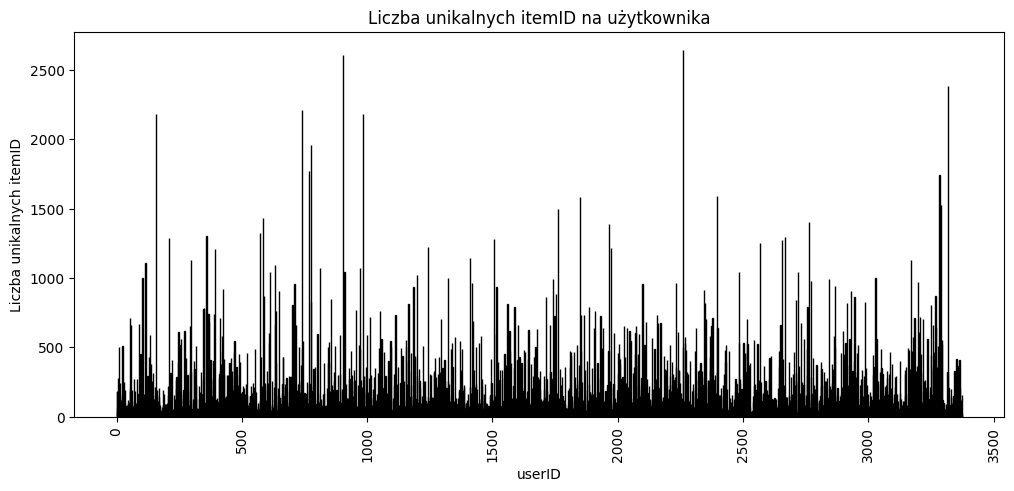

In [123]:
import matplotlib.pyplot as plt

# Sortowanie danych po userID (opcjonalne)
unique_counts = unique_counts.sort_values(by='userID')

# Tworzenie wykresu słupkowego
plt.figure(figsize=(12, 5))
plt.bar(unique_counts['userID'], unique_counts['unique_items_count'], color='skyblue', edgecolor='black')

# Opisy osi
plt.xlabel('userID')
plt.ylabel('Liczba unikalnych itemID')
plt.title('Liczba unikalnych itemID na użytkownika')

# Obracanie etykiet na osi X dla lepszej czytelności (jeśli dużo użytkowników)
plt.xticks(rotation=90)

# Wyświetlenie wykresu
plt.show()

### 3.2 Split the data using the python random splitter provided in utilities:

We split the full dataset into a `train` and `test` dataset to evaluate performance of the algorithm against a held-out set not seen during training. Because SAR generates recommendations based on user preferences, all users that are in the test set must also exist in the training set. For this case, we can use the provided `python_stratified_split` function which holds out a percentage (in this case 25%) of items from each user, but ensures all users are in both `train` and `test` datasets. Other options are available in the `dataset.python_splitters` module which provide more control over how the split occurs.


In [87]:
header = {
    "col_user": "userID",
    "col_item": "itemID",
    "col_rating": "rating",
    "col_timestamp": "timestamp",
    "col_prediction": "prediction",
}

In [88]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = data['timestamp'].astype('int64') // 10**9

train, test = python_stratified_split(
    data, ratio=0.75, col_user=header["col_user"], col_item=header["col_item"], seed=42
)

print(train.duplicated().any())


False


In [89]:
test.head()

,userID,itemID,rating,timestamp,title
86,1,2683,3.5,1094785650,Austin Powers: The Spy Who Shagged Me (1999)
2,1,32,3.5,1112484819,Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
107,1,3489,4.0,1112486024,Hook (1991)
92,1,2872,4.0,1112485697,Excalibur (1981)
157,1,7046,4.0,1112485934,"Witches of Eastwick, The (1987)"


In [90]:
train.head()


,userID,itemID,rating,timestamp,title
72,1,2140,4.0,1112485705,"Dark Crystal, The (1982)"
128,1,4915,3.0,1112486076,"Beastmaster, The (1982)"
171,1,8636,4.5,1112485493,Spider-Man 2 (2004)
10,1,293,4.0,1112484703,Léon: The Professional (a.k.a. The Professiona...
98,1,3000,3.5,1112484569,Princess Mononoke (Mononoke-hime) (1997)


In this case, for the illustration purpose, the following parameter values are used:

|Parameter|Value|Description|
|---------|---------|-------------|
|`similarity_type`|`jaccard`|Method used to calculate item similarity.|
|`time_decay_coefficient`|30|Period in days (term of $T$ shown in the formula of Section 1.2)|
|`time_now`|`None`|Time decay reference.|
|`timedecay_formula`|`True`|Whether time decay formula is used.|

In [91]:
print(header)
model = SAR(
    similarity_type="jaccard", 
    time_decay_coefficient=30, 
    time_now=None, 
    timedecay_formula=True, 
    **header
)

{'col_user': 'userID', 'col_item': 'itemID', 'col_rating': 'rating', 'col_timestamp': 'timestamp', 'col_prediction': 'prediction'}


In [92]:
model.fit(train)

2025-03-09 11:33:45 INFO     Collecting user affinity matrix
2025-03-09 11:33:45 INFO     Calculating time-decayed affinities
2025-03-09 11:33:45 INFO     Creating index columns
2025-03-09 11:33:45 INFO     Building user affinity sparse matrix
2025-03-09 11:33:45 INFO     Calculating item co-occurrence
2025-03-09 11:33:53 INFO     Calculating item similarity
2025-03-09 11:33:53 INFO     Using jaccard based similarity
2025-03-09 11:34:05 INFO     Done training


In [93]:
top_k = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

2025-03-09 11:34:05 INFO     Calculating recommendation scores
2025-03-09 11:34:08 INFO     Removing seen items


In [94]:
top_k.head()

,userID,itemID,prediction
0,1,1291,1.171849e-35
1,1,1214,1.161132e-35
2,1,2716,1.143989e-35
3,1,1270,1.134340e-35
4,1,5349,1.122877e-35


In [ ]:
top = model.recommend_k_items(test, top_k=1, remove_seen=True)

2025-03-09 11:34:09 INFO     Calculating recommendation scores
2025-03-09 11:34:12 INFO     Removing seen items


In [96]:
top.head()

,userID,itemID,prediction
0,1,1291,1.171849e-35
1,2,1240,5.471381e-52
2,3,2916,7.380791e-55
3,4,500,1.148885e-67
4,5,377,5.105514e-66


The final output from the `recommend_k_items` method generates recommendation scores for each user-item pair, which are shown as follows.

In [97]:
top_k_with_titles = top_k.join(
    data[["itemID", "title"]].drop_duplicates().set_index("itemID"),
    on="itemID",
    how="inner",
).sort_values(by=["userID", "prediction"], ascending=False)

top_k_with_titles.head(10)

,userID,itemID,prediction,title
33730,3374,480,2.977153e-53,Jurassic Park (1993)
33731,3374,1240,2.973709e-53,"Terminator, The (1984)"
33732,3374,377,2.772761e-53,Speed (1994)
33733,3374,47,2.752966e-53,Seven (a.k.a. Se7en) (1995)
33734,3374,457,2.742829e-53,"Fugitive, The (1993)"
33735,3374,780,2.738794e-53,Independence Day (a.k.a. ID4) (1996)
33736,3374,1214,2.731808e-53,Alien (1979)
33737,3374,593,2.730106e-53,"Silence of the Lambs, The (1991)"
33738,3374,356,2.669177e-53,Forrest Gump (1994)
33739,3374,296,2.666248e-53,Pulp Fiction (1994)


In [98]:
top_with_titles = top.join(
    data[["itemID", "title"]].drop_duplicates().set_index("itemID"),
    on="itemID",
    how="inner",
).sort_values(by=["userID", "prediction"], ascending=False)

top_with_titles.head(10)

,userID,itemID,prediction,title
3373,3374,480,2.977153e-53,Jurassic Park (1993)
3372,3373,6874,2.320702e-06,Kill Bill: Vol. 1 (2003)
3371,3372,592,6.716019e-68,Batman (1989)
3370,3371,380,2.610728e-68,True Lies (1994)
3369,3370,457,1.027509e-68,"Fugitive, The (1993)"
3368,3369,1234,1.071962e-54,"Sting, The (1973)"
3367,3368,4963,3.633231e-26,Ocean's Eleven (2001)
3366,3367,1265,2.944310e-49,Groundhog Day (1993)
3365,3366,1240,4.628683e-49,"Terminator, The (1984)"
3364,3365,1921,2.196497e-04,Pi (1998)


In [114]:
top_k_with_titles.count()

userID        33740
itemID        33740
prediction    33740
title         33740
dtype: int64

In [115]:
top_with_titles[top_with_titles["prediction"]>=0.1].count()

userID        139
itemID        139
prediction    139
title         139
dtype: int64

### 3.3 Evaluate the results

It should be known that the recommendation scores generated by multiplying the item similarity matrix $S$ and the user affinity matrix $A$ **DOES NOT** have the same scale with the original explicit ratings in the movielens dataset. That is to say, SAR algorithm is meant for the task of *recommending relevent items to users* rather than *predicting explicit ratings for user-item pairs*. 

To this end, ranking metrics like precision@k, recall@k, etc., are more applicable to evaluate SAR algorithm. The following illustrates how to evaluate SAR model by using the evaluation functions provided in Recommenders library.

In [99]:
# all ranking metrics have the same arguments
args = [test, top_k]
kwargs = dict(
    col_user="userID",
    col_item="itemID",
    col_rating="rating",
    col_prediction="prediction",
    relevancy_method="top_k",
    k=TOP_K,
)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg_at_k = ndcg_at_k(*args, **kwargs)
eval_precision_at_k = precision_at_k(*args, **kwargs)
eval_recall_at_k = recall_at_k(*args, **kwargs)

In [100]:
args1 = [test, top]
kwargs1 = dict(
    col_user="userID",
    col_item="itemID",
    col_rating="rating",
    col_prediction="prediction",
    relevancy_method="top_k",
    k=1,
)
eval_ndcg = ndcg_at_k(*args1, **kwargs1)
eval_precision = precision_at_k(*args1, **kwargs1)
eval_recall = recall_at_k(*args1, **kwargs1)

In [101]:
eval_mae = mae(test, top_k)
eval_rmse = rmse(test, top_k)

In [ ]:
top_with_titlesain, top)
eval_user_serendipity = user_serendipity(train, top)
eval_serendipity = serendipity(train, top)
eval_catalog_coverage = catalog_coverage(train, top)
eval_distributional_coverage = distributional_coverage(train, top)

/home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:1435: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_novelty = reco_item_novelty.agg({"product": "sum"})[0] / n_recommendations
/home/rs/anaconda3/envs/recsys25/lib/python3.9/site-packages/recommenders/evaluation/python_evaluation.py:1511: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform

In [103]:
# eval_f1 = f1(test, top)
# #eval_mrr = mrr(test, top)
# eval_accuracy = accuracy(test, top)
# eval_user_coverage = user_coverage(test, top)
# eval_item_coverage = item_coverage(test, top)

In [104]:
print("Precision:\t%f" % eval_precision,
      "Precision@K:\t%f" % eval_precision_at_k,
      "Recall:\t%f" % eval_recall,
      "Recall@K:\t%f" % eval_recall_at_k,
      "MAE:\t%f" % eval_mae,
      "RMSE:\t%f" % eval_rmse,
      "NDCG:\t%f" % eval_ndcg,
      "Novelty:\t%f" % eval_novelty,
      "Serendipity:\t%f" % eval_serendipity,
      "Catalog coverage:\t%f" % eval_catalog_coverage,
      "Distributional coverage:\t%f" % eval_distributional_coverage,
      sep='\n')

Precision:	0.343213
Precision@K:	0.239834
Recall:	0.020541
Recall@K:	0.127641
MAE:	3.988311
RMSE:	4.505952
NDCG:	0.343213
Novelty:	9.739434
Serendipity:	0.740253
Catalog coverage:	0.035974
Distributional coverage:	6.582903


In [105]:
# print("F1:\t%f" % eval_f1,
#       "Accuracy:\t%f" % eval_accuracy,
#       "User covarage:\t%f" % eval_user_coverage,
#       "Item coverage:\t%f" % eval_item_coverage,
#       sep='\n')

In [106]:
eval_historical_item_novelty

,itemID,item_novelty
0,1,8.658550
1,2,9.894479
2,3,10.664782
3,4,13.090266
4,5,10.527846
...,...,...
11531,128832,18.516531
11532,129354,18.516531
11533,129428,18.516531
11534,130219,18.516531


In [107]:
eval_user_item_serendipity

,userID,itemID,user_item_serendipity
0,1,1291,0.750124
1,2,1240,0.774082
2,3,2916,0.732381
3,4,500,0.627403
4,5,377,0.668087
...,...,...,...
3369,3370,457,0.637781
3370,3371,380,0.640951
3371,3372,592,0.594660
3372,3373,6874,0.722695


In [108]:
eval_user_serendipity

,userID,user_serendipity
0,1,0.750124
1,2,0.774082
2,3,0.732381
3,4,0.627403
4,5,0.668087
...,...,...
3369,3370,0.637781
3370,3371,0.640951
3371,3372,0.594660
3372,3373,0.722695


## References
Note SAR is a combinational algorithm that implements different industry heuristics. The followings are references that may be helpful in understanding the SAR logic and implementation. 

1. Badrul Sarwar, *et al*, "Item-based collaborative filtering recommendation algorithms", WWW, 2001.
2. Scipy (sparse matrix), url: https://docs.scipy.org/doc/scipy/reference/sparse.html
3. Asela Gunawardana and Guy Shani, "A survey of accuracy evaluation metrics of recommendation tasks", The Journal of Machine Learning Research, vol. 10, pp 2935-2962, 2009.	